<a href="https://colab.research.google.com/github/Elshraby/GradProj4/blob/main/17JUNE_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 📦 Install and Import Required Libraries
!pip install optuna --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 18.8 MB/s eta 0:00:00


In [4]:
def assign_configuration_ids(df, feature_columns):
    config_values = df[feature_columns].astype(str).agg('-'.join, axis=1)
    df['config_id'] = pd.factorize(config_values)[0]
    return df

def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    config_features = ['Airfoil', 'Number of Blades', 'Cord Length', 'Height',
                       'Diameter', 'Pitch Angle', 'Freestream Velocity']
    df = assign_configuration_ids(df, config_features)

    target_col = 'Power Coefficient'
    tsr_col = 'Tip Speed Ratio'

    X_config = df[config_features]
    X_tsr = df[[tsr_col]]
    y = df[[target_col]].values

    categorical_cols = X_config.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = [col for col in X_config.columns if col not in categorical_cols]

    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ])

    X_train_cfg, X_test_cfg, X_train_tsr, X_test_tsr, y_train, y_test = train_test_split(
        X_config, X_tsr, y, test_size=0.2, random_state=42
    )

    X_train_cfg_proc = preprocessor.fit_transform(X_train_cfg)
    X_test_cfg_proc = preprocessor.transform(X_test_cfg)

    y_scaler = StandardScaler()
    y_train_scaled = y_scaler.fit_transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)

    return (X_train_cfg_proc, X_test_cfg_proc, X_train_tsr.values, X_test_tsr.values,
            y_train_scaled, y_test_scaled, preprocessor, y_scaler)

In [5]:
# 📂 Load Data (adjust path if necessary)
X_train_cfg, X_test_cfg, X_train_tsr, X_test_tsr, y_train, y_test, preprocessor, y_scaler = load_and_preprocess_data('/content/Data.csv')
input_dim = X_train_cfg.shape[1]

In [6]:
def objective(trial):
    # Hyperparameters to tune
    hidden_dim1 = trial.suggest_int("hidden_dim1", 32, 128)
    hidden_dim2 = trial.suggest_int("hidden_dim2", 16, 64)
    predictor_dim = trial.suggest_int("predictor_dim", 16, 64)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    class TunableModel(nn.Module):
        def __init__(self, config_input_dim):
            super().__init__()
            self.encoder = nn.Sequential(
                nn.Linear(config_input_dim, hidden_dim1),
                nn.ReLU(),
                nn.Linear(hidden_dim1, hidden_dim2),
                nn.ReLU()
            )
            self.predictor = nn.Sequential(
                nn.Linear(hidden_dim2 + 1, predictor_dim),
                nn.ReLU(),
                nn.Linear(predictor_dim, 1)
            )

        def forward(self, config_x, tsr_x):
            config_feat = self.encoder(config_x)
            combined = torch.cat([config_feat, tsr_x], dim=1)
            return self.predictor(combined)

    model = TunableModel(input_dim)

    dataset = TensorDataset(torch.FloatTensor(X_train_cfg),
                            torch.FloatTensor(X_train_tsr),
                            torch.FloatTensor(y_train))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    model.train()
    for epoch in range(100):  # Keep small for faster tuning
        for config_batch, tsr_batch, y_batch in loader:
            optimizer.zero_grad()
            tsr_batch = tsr_batch.view(-1, 1)
            preds = model(config_batch, tsr_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(torch.FloatTensor(X_test_cfg), torch.FloatTensor(X_test_tsr))
        preds_unscaled = y_scaler.inverse_transform(preds.numpy())
        y_true_unscaled = y_scaler.inverse_transform(y_test)
        r2 = r2_score(y_true_unscaled, preds_unscaled)

    return 1.0 - r2  # We want to maximize R2, so minimize 1 - R2

In [7]:
# 🔍 Run Hyperparameter Search
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# 🏆 Best Hyperparameters
print("Best hyperparameters:")
print(study.best_trial.params)
print("Best R² score: {:.4f}".format(1.0 - study.best_value))

[I 2025-06-17 09:04:38,294] A new study created in memory with name: no-name-90dff3ca-891e-4682-8a3b-524e41f2139a
<ipython-input-6-2026934839>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2025-06-17 09:05:10,706] Trial 0 finished with value: 0.19585653787021018 and parameters: {'hidden_dim1': 107, 'hidden_dim2': 16, 'predictor_dim': 53, 'lr': 0.0002545671893745869, 'batch_size': 32}. Best is trial 0 with value: 0.19585653787021018.
<ipython-input-6-2026934839>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
[I 2025-06-17 09:05:59,859] Trial 1 finished with value: 0.10

Best hyperparameters:
{'hidden_dim1': 122, 'hidden_dim2': 51, 'predictor_dim': 57, 'lr': 0.002578058829065726, 'batch_size': 16}
Best R² score: 0.9203


In [8]:
# 🔁 Retrain Best Model with All Training Data
best_params = study.best_trial.params

class BestCpModel(nn.Module):
    def __init__(self, config_input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(config_input_dim, best_params["hidden_dim1"]),
            nn.ReLU(),
            nn.Linear(best_params["hidden_dim1"], best_params["hidden_dim2"]),
            nn.ReLU()
        )
        self.predictor = nn.Sequential(
            nn.Linear(best_params["hidden_dim2"] + 1, best_params["predictor_dim"]),
            nn.ReLU(),
            nn.Linear(best_params["predictor_dim"], 1)
        )

    def forward(self, config_x, tsr_x):
        config_feat = self.encoder(config_x)
        combined = torch.cat([config_feat, tsr_x], dim=1)
        return self.predictor(combined)

final_model = BestCpModel(input_dim)
optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params["lr"])
loss_fn = nn.MSELoss()

final_dataset = TensorDataset(torch.FloatTensor(X_train_cfg),
                              torch.FloatTensor(X_train_tsr),
                              torch.FloatTensor(y_train))
final_loader = DataLoader(final_dataset, batch_size=best_params["batch_size"], shuffle=True)

final_model.train()
for epoch in range(1000):
    for config_batch, tsr_batch, y_batch in final_loader:
        optimizer.zero_grad()
        tsr_batch = tsr_batch.view(-1, 1)
        preds = final_model(config_batch, tsr_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        optimizer.step()

✅ Final R² Score: 0.9232
📉 Final MSE: 0.001051


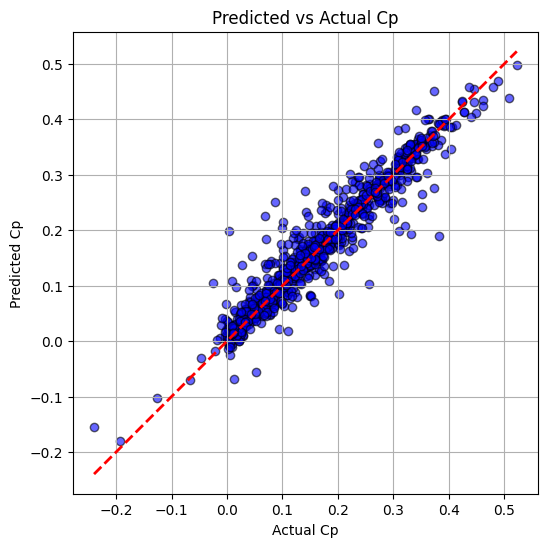

In [9]:
# 📈 Evaluate and Visualize
final_model.eval()
with torch.no_grad():
    test_preds = final_model(torch.FloatTensor(X_test_cfg), torch.FloatTensor(X_test_tsr))
    test_preds_unscaled = y_scaler.inverse_transform(test_preds.numpy())
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    r2_final = r2_score(y_test_unscaled, test_preds_unscaled)
    mse_final = mean_squared_error(y_test_unscaled, test_preds_unscaled)

    print(f"✅ Final R² Score: {r2_final:.4f}")
    print(f"📉 Final MSE: {mse_final:.6f}")

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test_unscaled, test_preds_unscaled, alpha=0.6, color='blue', edgecolor='k')
plt.plot([min(y_test_unscaled), max(y_test_unscaled)],
         [min(y_test_unscaled), max(y_test_unscaled)], 'r--', linewidth=2)
plt.title('Predicted vs Actual Cp')
plt.xlabel('Actual Cp')
plt.ylabel('Predicted Cp')
plt.grid(True)
plt.axis('equal')
plt.show()

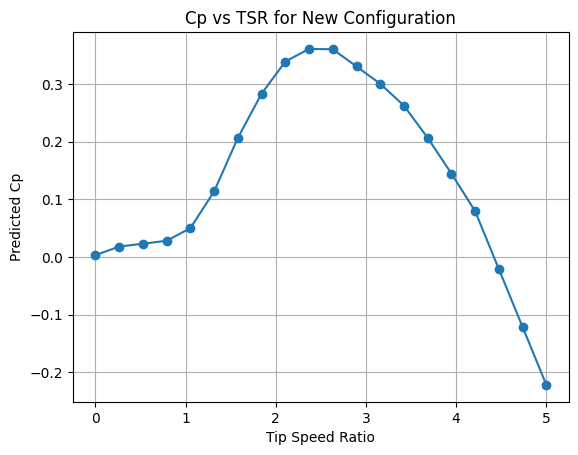

In [21]:
# 🔮 Predict Cp for a new configuration

# Define the prediction function
def predict_cp(model, config_df, tsr_values, preprocessor, y_scaler):
    """
    Predicts the power coefficient (Cp) for a given configuration and TSR values.

    Args:
        model (nn.Module): The trained PyTorch model.
        config_df (pd.DataFrame): DataFrame containing the configuration features.
                                  Must have the same structure as the training config data.
        tsr_values (np.ndarray): NumPy array of TSR values (shape: [n_samples, 1]).
        preprocessor (ColumnTransformer): The fitted ColumnTransformer used for preprocessing config features.
        y_scaler (StandardScaler): The fitted StandardScaler used for scaling the target variable.

    Returns:
        np.ndarray: Array of predicted Cp values (unscaled).
    """
    # Ensure model is in evaluation mode
    model.eval()

    # Preprocess the configuration features
    # Need to ensure the config_df has the same columns as used during training
    # and in the correct order for the preprocessor.
    # Assuming the config_features list defined earlier is available in the global scope.
    config_features = ['Airfoil', 'Number of Blades', 'Cord Length', 'Height',
                       'Diameter', 'Pitch Angle', 'Freestream Velocity']
    config_processed = preprocessor.transform(config_df[config_features])

    # Convert inputs to PyTorch tensors
    config_tensor = torch.FloatTensor(config_processed)
    tsr_tensor = torch.FloatTensor(tsr_values)

    # Make predictions
    with torch.no_grad():
        preds_scaled = model(config_tensor, tsr_tensor)

    # Inverse transform the predictions to get the unscaled Cp values
    preds_unscaled = y_scaler.inverse_transform(preds_scaled.numpy())

    return preds_unscaled

example_df = pd.DataFrame([{
    'Airfoil': 'NACA0018',
    'Number of Blades': 3,
    'Cord Length': 0.3,
    'Height': 2.0,
    'Diameter': 4.0,
    'Pitch Angle': 0.0,
    'Freestream Velocity': 8.0
}])

# Repeat the configuration DataFrame for each TSR value
repeated_config_df = example_df.loc[example_df.index.repeat(len(example_tsr))].reset_index(drop=True)


# Predict for a range of TSR values
example_tsr = np.linspace(0, 5, 20).reshape(-1, 1)
predicted_cp = predict_cp(final_model, repeated_config_df,
                          example_tsr, preprocessor, y_scaler)

plt.plot(example_tsr.flatten(), predicted_cp.flatten(), 'o-')
plt.xlabel("Tip Speed Ratio")
plt.ylabel("Predicted Cp")
plt.title("Cp vs TSR for New Configuration")
plt.grid(True)
plt.show()